In [1]:
import os
os.environ["OMP_NUM_THREADS"] = "8"
os.environ["DYLD_LIBRARY_PATH"] = "/Users/felipemustafa/Documents/interplay/petit/MultiNest/lib"
os.environ["LD_LIBRARY_PATH"] = "/Users/felipemustafa/Documents/interplay/petit/MultiNest/lib"

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import petitRADTRANS as prt
from petitRADTRANS.retrieval.models import madhushudhan_seager_transmission_modified, madhushudhan_seager_transmission
from models import madhu_seager_two_layers
from petitRADTRANS import physical_constants as cst
from petitRADTRANS.retrieval import Retrieval,RetrievalConfig
from petitRADTRANS.retrieval.models import Planet
from petitRADTRANS.retrieval.utils import log_prior
from petitRADTRANS.plotlib import plot_radtrans_opacities, plot_opacity_contributions
from matplotlib.patches import Rectangle
from petitRADTRANS.plotlib import plot_radtrans_opacities
from petitRADTRANS.chemistry.utils import compute_mean_molar_masses
from petitRADTRANS.retrieval.models import madhu_seager_patchy_transmission
from petitRADTRANS.retrieval.parameter import Parameter
from petitRADTRANS.plotlib.style import set_petitradtrans_plot_style

# set_petitradtrans_plot_style()
%matplotlib inline

In [3]:
planet = Planet.get("K2-18 b")
root_path = os.path.abspath(os.path.join(os.getcwd(), "../../petit"))

retrieval_config = RetrievalConfig(retrieval_name="K2-18b_seager_non_grey_clouds",
                                run_mode="retrieve",
                                amr=False,
                                scattering_in_emission=True,
                                pressures=np.logspace(-6, 2, 120),
                                  )

retrieval_config.add_data(
    "K2-18b_NIRISS",
    os.path.join(root_path, "spectra/K2-18b_NIRISS.txt"),
    data_resolution=700,
    model_resolution=1500,
    model_generating_function=madhushudhan_seager_transmission_modified,
    line_opacity_mode="c-k",
    external_radtrans_reference=None
)

retrieval_config.add_data(
    "K2-18b_NIRSPEC",
    os.path.join(root_path, "spectra/K2-18b_NIRSPEC.txt"),
    data_resolution=2700,
    model_resolution=1500,
    model_generating_function=madhushudhan_seager_transmission_modified,
    line_opacity_mode="c-k",
    external_radtrans_reference=None
)

retrieval_config.add_parameter('D_pl', False, value=124.265*cst.light_year)
retrieval_config.add_parameter('stellar_radius', False, value=planet.star_radius)
retrieval_config.add_parameter('planet_radius', False, value = 0.211*cst.r_jup)
retrieval_config.add_parameter('mass', False, value = 0.02807*cst.m_jup)

retrieval_config.add_parameter('P2', True, transform_prior_cube_coordinate = lambda x: log_prior(x, -6, 0))
retrieval_config.add_parameter('P1', True, transform_prior_cube_coordinate = lambda x: log_prior(x, -6, 0))
retrieval_config.add_parameter('log_P_set', True, transform_prior_cube_coordinate = lambda x: -6+6*x)
retrieval_config.add_parameter('T_set', True, transform_prior_cube_coordinate = lambda x: 500*x)
retrieval_config.add_parameter('alpha_0', True, transform_prior_cube_coordinate = lambda x:  0.02+1.98*x)
retrieval_config.add_parameter('alpha_1', True, transform_prior_cube_coordinate = lambda x: 0.02+1.98*x)
retrieval_config.add_parameter('fsed_H2O(l)', True, transform_prior_cube_coordinate = lambda x: log_prior(x, -3, 0))
retrieval_config.add_parameter('log_kzz', True, transform_prior_cube_coordinate = lambda x: 4+8*x)
retrieval_config.add_parameter('log_X_cb_H2O(l)', True, transform_prior_cube_coordinate = lambda x: -6+6*x)
retrieval_config.add_parameter('sigma_lnorm', True, transform_prior_cube_coordinate = lambda x: 1.05+1.95*x)
retrieval_config.add_parameter('log_Pbase_H2O(l)',  True, transform_prior_cube_coordinate = lambda x: -5+5*x)
retrieval_config.add_parameter('patchiness', True, transform_prior_cube_coordinate = lambda x: 1*x)

retrieval_config.set_rayleigh_species(['H2', 'He'])
retrieval_config.set_continuum_opacities(["H2-H2","H2-He"])
retrieval_config.set_line_species(['CH4', 'CO2', 'H2O', 'NH3'], eq=False, abund_lim = (-8.0,-0.1))

retrieval_config.parameters['P2'].plot_in_corner = True
retrieval_config.parameters['P2'].corner_ranges = (-6,0)
retrieval_config.parameters['P2'].corner_transform = lambda x: np.log10(x)
retrieval_config.parameters['P1'].plot_in_corner = True
retrieval_config.parameters['P1'].corner_ranges = (-6,0)
retrieval_config.parameters['P1'].corner_transform = lambda x: np.log10(x)
retrieval_config.parameters['log_P_set'].plot_in_corner = True
retrieval_config.parameters['log_P_set'].corner_ranges = (-6,0)
retrieval_config.parameters['T_set'].plot_in_corner = True
retrieval_config.parameters['T_set'].corner_ranges = (100,500)
retrieval_config.parameters['alpha_0'].plot_in_corner = True
retrieval_config.parameters['alpha_0'].corner_ranges = (-3,0)
retrieval_config.parameters['alpha_1'].plot_in_corner = True
retrieval_config.parameters['alpha_1'].corner_ranges = (-2,2)
retrieval_config.parameters['patchiness'].plot_in_corner = True
retrieval_config.parameters['patchiness'].corner_ranges = (0,1)
for spec in retrieval_config.line_species:
    retrieval_config.parameters[spec].plot_in_corner = True
    retrieval_config.parameters[spec].corner_ranges = (-8.2,0.2)

retrieval_config.plot_kwargs["spec_xlabel"] = 'Wavelength [micron]'
retrieval_config.plot_kwargs["spec_ylabel"] = r'$(R_{\rm P}/R_*)^2$ [ppm]'
retrieval_config.plot_kwargs["y_axis_scaling"] = 1e6 # so we have units of ppm
retrieval_config.plot_kwargs["xscale"] = 'linear'
retrieval_config.plot_kwargs["yscale"] = 'linear'

# Use at least ~100 samples to plot 3 sigma curves
retrieval_config.plot_kwargs["nsample"] = 100

retrieval_config.plot_kwargs["take_PTs_from"] = "K2-18b_NIRISS"
retrieval_config.plot_kwargs["temp_limits"] = [100, 800]
retrieval_config.plot_kwargs["press_limits"] = [1e-6, 1e2]

output_directory = os.path.join(root_path, "outputs")
retrieval = Retrieval(retrieval_config,
                      output_directory=output_directory,
                      use_mpi = False,        # Run locally, don't need to use MPI for massive parallelisation
                      evaluate_sample_spectra=False,      # Output the spectrum from nsample random samples.
                      use_prt_plot_style=True,
                      ultranest=False)        # Let's use pyMultiNestopacities = plot_radtrans_opacities(

retrieval.run(n_live_points=100,         # PMN number of live points. 400 is good for small retrievals, 4000 for large
              const_efficiency_mode=False, # Turn PMN const efficiency mode on or off (recommend on for large retrievals)
              resume=True,
              error_checking=False) 

Setting up Radtrans object for data 'K2-18b_NIRISS'...
Loading Radtrans opacities...
 Done.ng line opacities of species 'CH4.R1500' from file '/Users/felipemustafa/Documents/interplay/petit/input_data/opacities/lines/correlated_k/CH4/12C-1H4/12C-1H4__YT34to10.R1000_0.3-50mu.ktable.petitRADTRANS.h5'...
 Done.ng line opacities of species 'CO2.R1500' from file '/Users/felipemustafa/Documents/interplay/petit/input_data/opacities/lines/correlated_k/CO2/12C-16O2/12C-16O2__UCL-4000.R1000_0.3-50mu.ktable.petitRADTRANS.h5'...
 Done.ng line opacities of species 'H2O.R1500' from file '/Users/felipemustafa/Documents/interplay/petit/input_data/opacities/lines/correlated_k/H2O/1H2-16O/1H2-16O__POKAZATEL.R1000_0.3-50mu.ktable.petitRADTRANS.h5'...
 Done.ng line opacities of species 'NH3.R1500' from file '/Users/felipemustafa/Documents/interplay/petit/input_data/opacities/lines/correlated_k/NH3/14N-1H3/14N-1H3__CoYuTe.R1000_0.3-50mu.ktable.petitRADTRANS.h5'...
 Successfully loaded all line opacities
 L

In [4]:
## Getting samples
sample_dict, parameter_dict = retrieval.get_samples(output_directory=output_directory)
samples_use = sample_dict[retrieval.configuration.retrieval_name]
parameters_read = parameter_dict[retrieval.configuration.retrieval_name]

## Getting the best-fit model
log_l, best_fit_index = retrieval.get_best_fit_likelihood(samples_use)
sample_use = samples_use[:-1, best_fit_index]

best_fit_wavelengths, best_fit_spectrum = retrieval.get_best_fit_model(
                sample_use,
                parameters_read,
                model_generating_function=madhushudhan_seager_transmission_modified,
            )

Best fit likelihood = 28828.69
Loading Radtrans opacities...
 Done.ng line opacities of species 'CH4' from file '/Users/felipemustafa/Documents/interplay/petit/input_data/opacities/lines/correlated_k/CH4/12C-1H4/12C-1H4__YT34to10.R1000_0.3-50mu.ktable.petitRADTRANS.h5'...
 Done.ng line opacities of species 'CO2' from file '/Users/felipemustafa/Documents/interplay/petit/input_data/opacities/lines/correlated_k/CO2/12C-16O2/12C-16O2__UCL-4000.R1000_0.3-50mu.ktable.petitRADTRANS.h5'...
 Done.ng line opacities of species 'H2O' from file '/Users/felipemustafa/Documents/interplay/petit/input_data/opacities/lines/correlated_k/H2O/1H2-16O/1H2-16O__POKAZATEL.R1000_0.3-50mu.ktable.petitRADTRANS.h5'...
 Done.ng line opacities of species 'NH3' from file '/Users/felipemustafa/Documents/interplay/petit/input_data/opacities/lines/correlated_k/NH3/14N-1H3/14N-1H3__CoYuTe.R1000_0.3-50mu.ktable.petitRADTRANS.h5'...
 Successfully loaded all line opacities
 Loading CIA opacities for H2-H2 from file '/Users

<>:2: SyntaxWarning: invalid escape sequence '\s'
<>:3: SyntaxWarning: invalid escape sequence '\s'
<>:34: SyntaxWarning: invalid escape sequence '\c'
<>:2: SyntaxWarning: invalid escape sequence '\s'
<>:3: SyntaxWarning: invalid escape sequence '\s'
<>:34: SyntaxWarning: invalid escape sequence '\c'
/var/folders/7n/vnhc1_6x3xsdp541n54p1r9c0000gn/T/ipykernel_96628/2398162007.py:2: SyntaxWarning: invalid escape sequence '\s'
  niriss = pd.read_csv(os.path.join(root_path, "spectra/K2-18b_NIRISS_low_res.txt"), skiprows=1, names=["wl", "td", "td_e"], sep="\s+")
/var/folders/7n/vnhc1_6x3xsdp541n54p1r9c0000gn/T/ipykernel_96628/2398162007.py:3: SyntaxWarning: invalid escape sequence '\s'
  nirspec = pd.read_csv(os.path.join(root_path, "spectra/K2-18b_NIRSPEC_low_res.txt"), skiprows=1, names=["wl", "td", "td_e"], sep="\s+")
/var/folders/7n/vnhc1_6x3xsdp541n54p1r9c0000gn/T/ipykernel_96628/2398162007.py:34: SyntaxWarning: invalid escape sequence '\c'
  ax.set_title(f'Best fit spectra, $\chi_v^2$

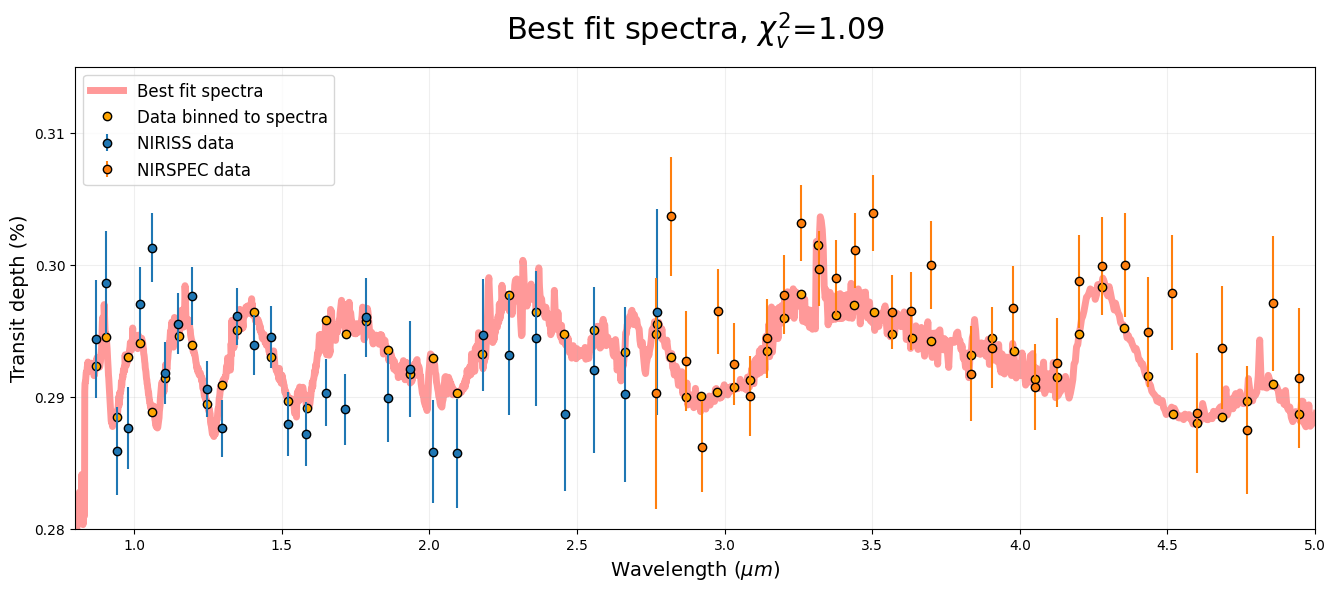

In [5]:
## Loading the low resolution spectra
niriss = pd.read_csv(os.path.join(root_path, "spectra/K2-18b_NIRISS_low_res.txt"), skiprows=1, names=["wl", "td", "td_e"], sep="\s+")
nirspec = pd.read_csv(os.path.join(root_path, "spectra/K2-18b_NIRSPEC_low_res.txt"), skiprows=1, names=["wl", "td", "td_e"], sep="\s+")

## Binning the best fit model to spectra data
idx_niriss = []
idx_nirspec = []
for i in range(niriss["wl"].shape[0]):
    minIndex = np.argmin((best_fit_wavelengths-niriss["wl"][i])**2)
    idx_niriss.append(minIndex)
    
for j in range(nirspec["wl"].shape[0]):
    minIndex = np.argmin((best_fit_wavelengths-nirspec["wl"][j])**2)
    idx_nirspec.append(minIndex)

## Calculating the reduced chi squared
chi2 = retrieval.get_reduced_chi2_from_model(best_fit_wavelengths, best_fit_spectrum, subtract_n_parameters = True)

## Plot of the best-fit spectra
ax = plt.figure(figsize=(16,6)).gca()
ax.plot(best_fit_wavelengths, best_fit_spectrum*100, 
        color="red", alpha=0.4, linewidth=5, zorder=1, label="Best fit spectra")
ax.plot(best_fit_wavelengths[idx_niriss], best_fit_spectrum[idx_niriss]*100, 'o',
          color="orange", markeredgecolor="k", zorder=2, label="Data binned to spectra")
ax.plot(best_fit_wavelengths[idx_nirspec], best_fit_spectrum[idx_nirspec]*100, 'o',
          color="orange", markeredgecolor="k", zorder=2)
ax.errorbar(niriss["wl"], niriss["td"]*100, yerr = niriss["td_e"]*100, fmt='o', markeredgecolor="k", label="NIRISS data", zorder=3)
ax.errorbar(nirspec["wl"], nirspec["td"]*100, yerr = nirspec["td_e"]*100, fmt='o', markeredgecolor="k", label="NIRSPEC data", zorder=3)
ax.set(xlim=(0.8, 5),
       xticks=np.arange(1, 5.5, 0.5), 
       ylim=(0.28, 0.315),
       yticks=[0.28, 0.29, 0.30, 0.31],
      )
ax.set_title(f'Best fit spectra, $\chi_v^2$={chi2:.2f}', pad = 20, fontsize=22)
ax.set_ylabel('Transit depth (%)', fontsize=14)
ax.set_xlabel(r'Wavelength (${\mu m}$)', fontsize=14)
ax.grid(alpha=0.2)
ax.legend(loc="upper left", fontsize=12)
plt.show()

In [6]:
## Calculating the forward best-fit model

parameters = {
    'stellar_radius': Parameter('stellar_radius', False, value= planet.star_radius),
    'planet_radius': Parameter('planet_radius', False, value= 0.211*cst.r_jup),
    'mass': Parameter('mass', False, value= 0.02807*cst.m_jup),
    'P2': Parameter('P2', False, value = retrieval.best_fit_parameters['P2'].value),
    'P1': Parameter('P1', False, value = retrieval.best_fit_parameters['P1'].value),
    'log_P_set': Parameter('log_P_set', False, value = retrieval.best_fit_parameters['log_P_set'].value),
    'T_set': Parameter('T_set', False, value = retrieval.best_fit_parameters['T_set'].value),
    'alpha_0': Parameter('alpha_0', False, value = retrieval.best_fit_parameters['alpha_0'].value),
    'alpha_1': Parameter('alpha_1', False, value = retrieval.best_fit_parameters['alpha_1'].value),
    'log_X_cb_H2O(l)': Parameter('log_X_cb_H2O(l)', False, value = retrieval.best_fit_parameters['log_X_cb_H2O(l)'].value),
    'fsed_H2O(l)': Parameter('fsed_H2O(l)', False, value = retrieval.best_fit_parameters['fsed_H2O(l)'].value),
    'log_Pbase_H2O(l)': Parameter('log_Pbase_H2O(l)', False, value = retrieval.best_fit_parameters['log_Pbase_H2O(l)'].value),
    'log_kzz': Parameter('log_kzz', False, value = retrieval.best_fit_parameters['log_kzz'].value),
    'sigma_lnorm': Parameter('sigma_lnorm', False, value = retrieval.best_fit_parameters['sigma_lnorm'].value),
    'CH4': Parameter('CH4', False, value= retrieval.best_fit_parameters['CH4'].value),
    'CO2': Parameter('CO2', False, value= retrieval.best_fit_parameters['CO2'].value),
    'H2O': Parameter('H2O', False, value= retrieval.best_fit_parameters['H2O'].value),
    'NH3': Parameter('NH3', False, value= retrieval.best_fit_parameters['NH3'].value),
}

line_species = [
    'CH4',
    'CO2',
    'H2O',
    'NH3'
]

rayleigh_species = ['H2', 'He']
continuum_opacities = ['H2-H2', 'H2-He']
cloud_species = ['H2O(l)']
pressures = np.logspace(-6,2,120)
wls = np.concatenate([retrieval_config.data['K2-18b_NIRISS'].wavelengths, retrieval_config.data['K2-18b_NIRSPEC'].wavelengths])

atmosphere = prt.radtrans.Radtrans(
    pressures=pressures,
    line_species=line_species,
    rayleigh_species=rayleigh_species,
    gas_continuum_contributors=continuum_opacities,
    cloud_species=cloud_species,
    wavelength_boundaries=[wls[0], wls[-1]]
)

wavelength, model = madhushudhan_seager_transmission_modified(atmosphere, parameters, amr = False, pt_plot_mode = False)
pressure,temperature = madhushudhan_seager_transmission_modified(atmosphere, parameters, amr = False, pt_plot_mode = True)

Loading Radtrans opacities...
 Done.ng line opacities of species 'CH4' from file '/Users/felipemustafa/Documents/interplay/petit/input_data/opacities/lines/correlated_k/CH4/12C-1H4/12C-1H4__YT34to10.R1000_0.3-50mu.ktable.petitRADTRANS.h5'...
 Done.ng line opacities of species 'CO2' from file '/Users/felipemustafa/Documents/interplay/petit/input_data/opacities/lines/correlated_k/CO2/12C-16O2/12C-16O2__UCL-4000.R1000_0.3-50mu.ktable.petitRADTRANS.h5'...
 Done.ng line opacities of species 'H2O' from file '/Users/felipemustafa/Documents/interplay/petit/input_data/opacities/lines/correlated_k/H2O/1H2-16O/1H2-16O__POKAZATEL.R1000_0.3-50mu.ktable.petitRADTRANS.h5'...
 Done.ng line opacities of species 'NH3' from file '/Users/felipemustafa/Documents/interplay/petit/input_data/opacities/lines/correlated_k/NH3/14N-1H3/14N-1H3__CoYuTe.R1000_0.3-50mu.ktable.petitRADTRANS.h5'...
 Successfully loaded all line opacities
 Loading CIA opacities for H2-H2 from file '/Users/felipemustafa/Documents/interp

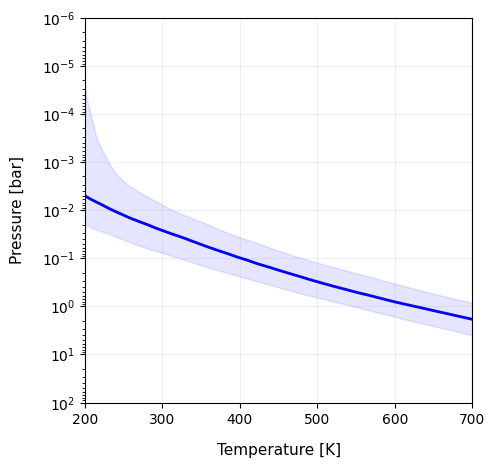

In [8]:
import numpy as np
import matplotlib.pyplot as plt
from petitRADTRANS.physics import madhu_seager_2009_modified, madhu_seager_2009_test

# Define the number of Monte Carlo samples
N_samples = 1000  

# Storage for temperature profiles
T_profiles = np.zeros((N_samples, len(pressure)))

# Define parameter bounds (replace with actual values)
P2_bounds = (10**(-5.44), 10**(-3.66))
P1_bounds = (10**(-5.3), 10**(-2.5))
log_P_set_bounds = (-5, -2.2)
T_set_bounds = (192, 408)
alpha_0_bounds = (0.77, 1.69)
alpha_1_bounds = (0.347, 0.463)


# Loop over Monte Carlo samples
for i in range(N_samples):
    # Sample parameters uniformly within bounds
    P2_sample = np.random.uniform(*P2_bounds)
    P1_sample = np.random.uniform(*P1_bounds)
    log_P_set_sample = np.random.uniform(*log_P_set_bounds)
    T_set_sample = np.random.uniform(*T_set_bounds)
    alpha_0_sample = np.random.uniform(*alpha_0_bounds)
    alpha_1_sample = np.random.uniform(*alpha_1_bounds)
    
    # Compute the temperature profile for this sample
    T_profiles[i, :] = madhu_seager_2009_test(
        pressure,
        pressure[0],
        P1_sample,
        P2_sample,
        np.exp(log_P_set_sample),
        T_set_sample,
        alpha_0_sample,
        alpha_1_sample,
        0.5,
        0.5
    )

# Compute uncertainty bounds (16th and 84th percentiles)
T_lower = np.percentile(T_profiles, 20, axis=0)
T_upper = np.percentile(T_profiles, 80, axis=0)
T_best_fit = np.percentile(T_profiles, 50, axis=0)  # Median best-fit profile

# Plot
fig, ax = plt.subplots(figsize=(5, 5))
ax.plot(T_best_fit, pressure, linewidth=2, color='blue', label="Best-fit Profile")
ax.fill_betweenx(pressure, T_lower, T_upper, color='blue', alpha=0.1, label="1σ region")

ax.set(xlim=(200, 700), ylim=(1e-6, 1e2), yscale='log')
ax.set_xlabel("Temperature [K]", fontsize=11, labelpad=12)
ax.set_ylabel(r"Pressure [bar]", fontsize=11, labelpad=12)
ax.invert_yaxis()

# ax.legend()
ax.grid(alpha=0.2)
plt.show()

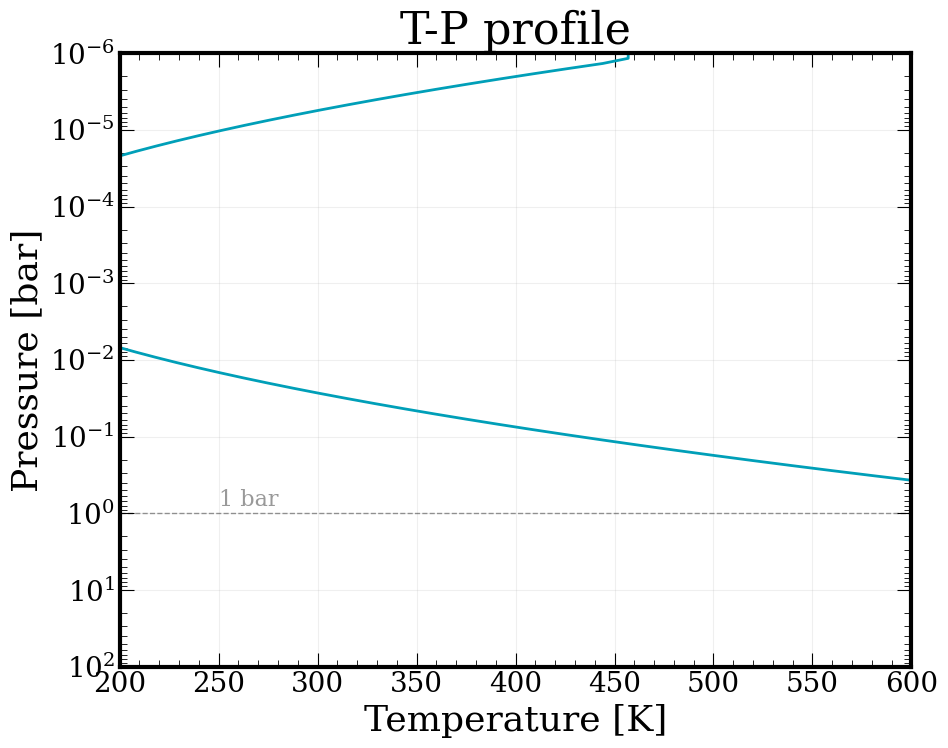

In [7]:
# fig, ax = retrieval.plot_pt(sample_dict,parameters_read, contribution=False)
# ax.axhline(y=0.986923, linestyle="--", color="k", linewidth=1, alpha=0.4)
# ax.invert_yaxis()
# plt.show()

# fig, ax = retrieval.plot_pt(sample_dict,parameters_read, contribution=False)
# ax.axhline(y=0.986923, linestyle="--", color="k", linewidth=1, alpha=0.4)
# ax.text(200, 0.8, "1 bar", fontsize=16, alpha=0.4) 
# ax.invert_yaxis()
# plt.show()

## Temperature-pressure profile
fig, ax = plt.subplots(figsize=(10,8))
ax.plot(temperature, pressure, linewidth = 2)
ax.set(xlabel="Temperature [K]",
       ylabel="Pressure [bar]",
       xlim=(200, 600),
       ylim=(1e2,1e-6),
       yscale="log",
       title="T-P profile"
      )
ax.axhline(y=0.986923, linestyle="--", color="k", linewidth=1, alpha=0.4)
ax.text(250, 0.8, "1 bar", fontsize=16, alpha=0.4) 
ax.grid(alpha=0.2)
plt.show()

In [11]:
retrieval_config.parameters['P2'].plot_in_corner = True
retrieval_config.parameters['P2'].corner_ranges = (-6,0)
retrieval_config.parameters['P2'].corner_transform = lambda x: np.log10(x)
retrieval_config.parameters['P1'].plot_in_corner = True
retrieval_config.parameters['P1'].corner_ranges = (-6,0)
retrieval_config.parameters['P1'].corner_transform = lambda x: np.log10(x)
retrieval_config.parameters['log_P_set'].plot_in_corner = True
retrieval_config.parameters['log_P_set'].corner_ranges = (-6,0)
retrieval_config.parameters['T_set'].plot_in_corner = True
retrieval_config.parameters['T_set'].corner_ranges = (100,500)
retrieval_config.parameters['alpha_0'].plot_in_corner = False
retrieval_config.parameters['alpha_0'].corner_ranges = (0,2)
retrieval_config.parameters['alpha_1'].plot_in_corner = True
retrieval_config.parameters['alpha_1'].corner_ranges = (0,2)
retrieval_config.parameters['patchiness'].plot_in_corner = True
retrieval_config.parameters['patchiness'].corner_ranges = (0,1)
# retrieval_config.parameters['log_Pcloud'].plot_in_corner = False
# retrieval_config.parameters['log_Pcloud'].corner_ranges = (-6,1)

## Corner plot
retrieval.plot_corner(sample_dict, parameter_dict, parameters_read, plot_best_fit=True,title_kwargs= {"fontsize" : 10})
plt.show()


Making corner plot


ValueError: setting an array element with a sequence. The requested array has an inhomogeneous shape after 1 dimensions. The detected shape was (16,) + inhomogeneous part.


Plotting Best-fit contribution function
Best fit likelihood = 28832.74
Loading Radtrans opacities...
 Loading line opacities of species 'CH4' from file '/home/juan/petitRADTRANS/input_data/opacities/lines/correlated_k/CH4/12C-1H4/12C-1H4__YT34to10.R1000_0.3-50mu.ktable.petitRADTRANS.h5'... Done.
 Loading line opacities of species 'CO2' from file '/home/juan/petitRADTRANS/input_data/opacities/lines/correlated_k/CO2/12C-16O2/12C-16O2__UCL-4000.R1000_0.3-50mu.ktable.petitRADTRANS.h5'... Done.
 Loading line opacities of species 'H2O' from file '/home/juan/petitRADTRANS/input_data/opacities/lines/correlated_k/H2O/1H2-16O/1H2-16O__POKAZATEL.R1000_0.3-50mu.ktable.petitRADTRANS.h5'... Done.
 Loading line opacities of species 'NH3' from file '/home/juan/petitRADTRANS/input_data/opacities/lines/correlated_k/NH3/14N-1H3/14N-1H3__CoYuTe.R1000_0.3-50mu.ktable.petitRADTRANS.h5'... Done.
 Successfully loaded all line opacities
 Loading CIA opacities for H2-H2 from file '/home/juan/petitRADTRANS/inpu

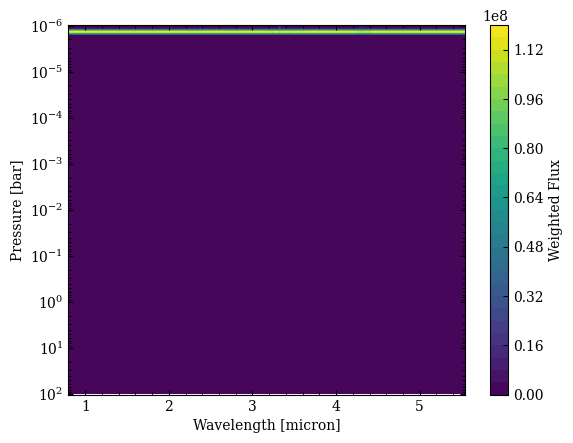

In [14]:
## Plotting the contribution function of each wavelength and each pressure
retrieval.plot_contribution(samples_use, parameters_read)
plt.show()

Generating temporary Radtrans object with 'line_species': 'CH4'
Loading Radtrans opacities...
 Loading line opacities of species 'CH4' from file '/home/juan/petitRADTRANS/input_data/opacities/lines/correlated_k/CH4/12C-1H4/12C-1H4__YT34to10.R1000_0.3-50mu.ktable.petitRADTRANS.h5'... Done.
 Successfully loaded all line opacities
Successfully loaded all opacities
Loading Radtrans opacities...
 Loading line opacities of species 'CH4' from file '/home/juan/petitRADTRANS/input_data/opacities/lines/correlated_k/CH4/12C-1H4/12C-1H4__YT34to10.R1000_0.3-50mu.ktable.petitRADTRANS.h5'... Done.
 Successfully loaded all line opacities
Successfully loaded all opacities
Generating temporary Radtrans object with 'line_species': 'CO2'
Loading Radtrans opacities...
 Loading line opacities of species 'CO2' from file '/home/juan/petitRADTRANS/input_data/opacities/lines/correlated_k/CO2/12C-16O2/12C-16O2__UCL-4000.R1000_0.3-50mu.ktable.petitRADTRANS.h5'... Done.
 Successfully loaded all line opacities
Succ

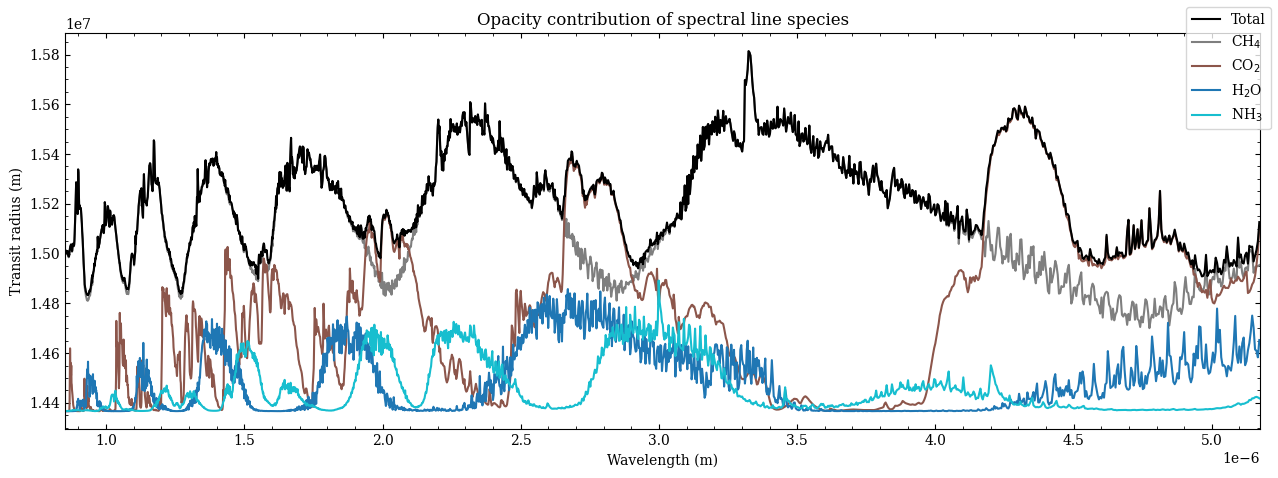

In [15]:
## Plotting opacity contribution of the different chemical species

abundances = {
    'CH4': np.ones_like(pressure)*10**retrieval.best_fit_parameters['CH4'].value,
    'CO2': np.ones_like(pressure)*10**retrieval.best_fit_parameters['CO2'].value,
    'H2O': np.ones_like(pressure)*10**retrieval.best_fit_parameters['H2O'].value,
    'NH3': np.ones_like(pressure)*10**retrieval.best_fit_parameters['NH3'].value,
}

msum = 0.0

for mol in abundances.keys():
    msum += abundances[mol]

abundances['H2'] = 0.766 * (1.0 - msum) * np.ones_like(pressures)
abundances['He'] = 0.234 * (1.0 - msum) * np.ones_like(pressures)

plot_opacity_contributions(atmosphere,
                           include=['CH4', 'CO2', 'H2O', 'NH3', 'Total'],
                           mode="transmission",
                           temperatures=temperature, 
                           mass_fractions=abundances,
                           mean_molar_masses=compute_mean_molar_masses(abundances),
                           reference_gravity=planet.reference_gravity,
                           reference_pressure=planet.reference_pressure,
                           planet_radius=0.211*cst.r_jup)
plt.title('Opacity contribution of spectral line species')
plt.show()

Caso p_set en layer 2
P_set: 0.0051690200234656165, T_set: 183.61915163134546
P_0: 1e-06, T_0: 456.9101793049057
P_1: 1.2215744504975513e-06, T_1: 456.93353856089095
P_2: 0.00038891954998462283, T_2: 114.64723325518639


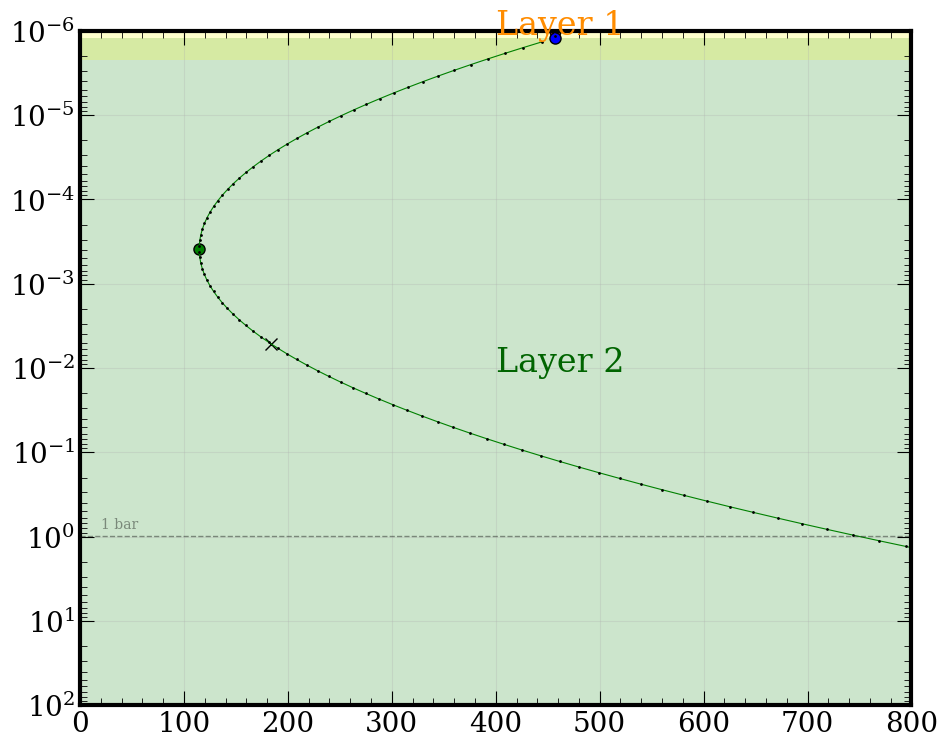

In [12]:
p_0 = retrieval.configuration.pressures[0]
p_1 = retrieval.best_fit_parameters['P1'].value
p_2 = retrieval.best_fit_parameters['P2'].value
p_set = np.exp(retrieval.best_fit_parameters['log_P_set'].value)
t_set = retrieval.best_fit_parameters['T_set'].value
a_0 = retrieval.best_fit_parameters['alpha_0'].value
a_1 = retrieval.best_fit_parameters['alpha_1'].value
b_0 = 0.5
b_1 = 0.5

model = madhu_seager_two_layers(retrieval.configuration.pressures, 
                                   [p_0, p_1, p_2],
                                   [p_set, t_set],
                                   [a_0, a_1],
                                   [b_0, b_1])


ax = plt.figure(figsize=(10,8)).gca()
ax.plot(model['t_0'], p_0, color='brown', marker='o')
ax.plot(model['t_1'], p_1, color='blue', marker='o')
ax.plot(model['t_2'], p_2, color='green', marker='o')
ax.plot(t_set, p_set, color='black', marker='x')
ax.plot(model["region_2"]["ts"], model["region_2"]["ps"], '.-', color='green', linewidth=0.8, markersize=2)
ax.plot(model["region_1"]["ts"], model["region_1"]["ps"], '.-', color='blue', linewidth=0.8, markersize=2)
ax.text(400, np.sqrt(p_0 * p_1), 'Layer 1', color='darkorange')
ax.text(400, np.sqrt(1e2 * p_1), 'Layer 2', color='darkgreen')
ax.set(yscale='log')
ax.set(ylim=(1e-6, 1e2), xlim=(0, 800))
ax.axhline(y=0.986923, linestyle="--", color="k", linewidth=1, alpha=0.4)
ax.text(20, 0.8, "1 bar", fontsize=10, alpha=0.4) 
ax.invert_yaxis()
ax.add_patch(Rectangle((0, p_1), 1500, 200, facecolor='green', alpha=0.2))
ax.add_patch(Rectangle((p_1, 1e-6), 1500, p_1, facecolor='yellow', alpha=0.2))
ax.grid(alpha=0.3)
print(f'P_set: {p_set}, T_set:', model['t_set'])
print(f'P_0: {p_0}, T_0:', model['t_0'])
print(f'P_1: {p_1}, T_1:', model['t_1'])
print(f'P_2: {p_2}, T_2:', model['t_2'])
plt.show()

In [7]:
parameters = {
    'stellar_radius': Parameter('stellar_radius', False, value= planet.star_radius),
    'planet_radius': Parameter('planet_radius', False, value= 0.211*cst.r_jup),
    'mass': Parameter('mass', False, value= 0.02807*cst.m_jup),
    'P1': Parameter('P1', False, value= retrieval.best_fit_parameters['P1'].value),
    'P2': Parameter('P2', False, value= retrieval.best_fit_parameters['P2'].value),
    'log_P_set': Parameter('log_P_set', False, value= retrieval.best_fit_parameters['log_P_set'].value),
    'T_set': Parameter('T_set', False, value= retrieval.best_fit_parameters['T_set'].value),
    'alpha_0': Parameter('alpha_0', False, value= retrieval.best_fit_parameters['alpha_0'].value),
    'alpha_1': Parameter('alpha_1', False, value= retrieval.best_fit_parameters['alpha_1'].value),
    'log_Pcloud': Parameter('log_Pcloud', False, value= retrieval.best_fit_parameters['log_Pcloud'].value),
    'patchiness': Parameter('patchiness', False, value= retrieval.best_fit_parameters['patchiness'].value),
    'CH4': Parameter('CH4', False, value= retrieval.best_fit_parameters['CH4'].value),
    'CO2': Parameter('CO2', False, value= retrieval.best_fit_parameters['CO2'].value),
    'H2O': Parameter('H2O', False, value= retrieval.best_fit_parameters['H2O'].value),
    'NH3': Parameter('NH3', False, value= retrieval.best_fit_parameters['NH3'].value),
}

line_species = [
    'CH4',
    'CO2',
    'H2O',
    'NH3'
]

rayleigh_species = ['H2', 'He']
continuum_opacities = ['H2-H2', 'H2-He']
cloud_species = []
pressures = np.logspace(-6,2,100)
wls = np.concatenate([retrieval_config.data['K2-18b_NIRISS'].wavelengths, retrieval_config.data['K2-18b_NIRSPEC'].wavelengths])

atmosphere = prt.radtrans.Radtrans(
    pressures=pressures,
    line_species=line_species,
    rayleigh_species=rayleigh_species,
    gas_continuum_contributors=continuum_opacities,
    cloud_species=cloud_species,
    wavelength_boundaries=[wls[0], wls[-1]]
)

wavelength, model = madhushudhan_seager_transmission_modified(atmosphere, parameters, amr = False, pt_plot_mode = False)
pressure,temperature = madhushudhan_seager_transmission_modified(atmosphere, parameters, amr = False, pt_plot_mode = True)

Loading Radtrans opacities...
 Loading line opacities of species 'CH4' from file '/home/juan/petitRADTRANS/input_data/opacities/lines/correlated_k/CH4/12C-1H4/12C-1H4__YT34to10.R1000_0.3-50mu.ktable.petitRADTRANS.h5'... Done.
 Loading line opacities of species 'CO2' from file '/home/juan/petitRADTRANS/input_data/opacities/lines/correlated_k/CO2/12C-16O2/12C-16O2__UCL-4000.R1000_0.3-50mu.ktable.petitRADTRANS.h5'... Done.
 Loading line opacities of species 'H2O' from file '/home/juan/petitRADTRANS/input_data/opacities/lines/correlated_k/H2O/1H2-16O/1H2-16O__POKAZATEL.R1000_0.3-50mu.ktable.petitRADTRANS.h5'... Done.
 Loading line opacities of species 'NH3' from file '/home/juan/petitRADTRANS/input_data/opacities/lines/correlated_k/NH3/14N-1H3/14N-1H3__CoYuTe.R1000_0.3-50mu.ktable.petitRADTRANS.h5'... Done.
 Successfully loaded all line opacities
 Loading CIA opacities for H2-H2 from file '/home/juan/petitRADTRANS/input_data/opacities/continuum/collision_induced_absorptions/H2--H2/H2--H2-N